# Module 4: Noise & Quantum Error Basics
- Understanding Quantum Noise

- Real quantum devices are noisy → decoherence, gate errors, readout errors.

- Decoherence: loss of quantum information due to interaction with the environment.

- Relaxation (T1): qubit decays from |1⟩ → |0⟩.

- Dephasing (T2): phase info lost, superposition collapses into mixed state.

In [2]:
# Qiskit Noise Models (Simulation)

# Use Aer’s noise module to create noisy simulations.

# Example: depolarizing noise, amplitude damping, readout error.

from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, ReadoutError

# Create a noise Model
noise_model = NoiseModel()

# Depolarizing error on single qubit and 2 qubit gates.
error1 = depolarizing_error(0.01, 1) # 1% single qubit noise
error2 = depolarizing_error(0.05, 2) # 5% two qubit noise

# Add to Model
noise_model.add_all_qubit_quantum_error(error1, ['u1', 'u2','u3'])
noise_model.add_all_qubit_quantum_error(error2, ['cx'])

# Simple readout error
readout_error = ReadoutError([[0.9,0.1],[0.2,0.8]])
noise_model.add_all_qubit_readout_error(readout_error)

In [5]:
# Hands-on: Bell State with Noise
# Compare Bell state with and without noise.
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

sim = Aer.get_backend('aer_simulator')

# Bell state circuit
qc = QuantumCircuit(2,2)
qc.h(0); qc.cx(0,1)
qc.measure([0,1],[0,1])

# Ideal run
ideal = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
print("Ideal:", ideal)

# Noisy run
noisy = sim.run(transpile(qc, sim), shots=1000, noise_model=noise_model).result().get_counts()
print("Noisy:", noisy)


Ideal: {'00': 499, '11': 501}
Noisy: {'00': 439, '10': 132, '01': 125, '11': 304}


# Quantum Error Mitigation (Basic Intro)

- Error Correction (full codes like Shor’s or surface codes) = too heavy for today’s devices.

- Error Mitigation = practical workaround.

- Measurement Error Mitigation: calibrate readout bias.

- Zero-Noise Extrapolation (ZNE): run at scaled noise and extrapolate to 0.

- Probabilistic Error Cancellation: statistically correct outcomes.

In [ ]:
# Example 
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
# Advanced error mitigation available in IBM Runtime (not just local Aer)


- Deutsch–Jozsa Algorithm
- Goal: Decide if an oracle f:{0,1}
- n →{0,1} is constant or balanced in a single oracle call.
- Concept notes (Markdown)

- Prepare 
- 𝑛 input qubits in ∣0⟩ ⊗n and one ancilla in ∣1⟩.
- Apply H to all qubits, run oracle 𝑈𝑓, apply H to the n inputs measure.
- Output rule:
- If all input qubits measure 0 → constant
- Otherwise → balanced
- Code: helper + two oracles (1 constant, 1 balanced)

In [1]:
# Code: helper + two oracles (1 constant, 1 balanced)
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
sim = AerSimulator()

def dj_circuit(n, oracle):
    qc = QuantumCircuit(n+1, n)  # n inputs +1 ancilla
    qc.x(n)  # ancilla to |1>
    qc.h(range(n+1))  # H on all qubits
    oracle(qc)  # apply oracle
    qc.h(range(n))  # H on input qubits
    qc.measure(range(n), range(n))  # measure
    return qc

# Example oracles
def oracle_constant_zero(qc):
    # f(x) = 0 for all x then do nothing
    return qc

def oracle_balanced_parity(qc):
    # f(x)=x0 XOR x1 XOR ... (parity): implement via cascaded CNOTs into ancilla
    n = qc.num_qubits - 1
    for i in range(n):
        qc.cx(i, n)

# Run both
for name, oracle in [("constant 0", oracle_constant_zero), ("balanced parity", oracle_balanced_parity)]:
    qc = dj_circuit(n=3, oracle=oracle)
    res = sim.run(transpile(qc, sim), shots=1024).result().get_counts()
    print(name, res)
    (plot_histogram(res))


constant 0 {'000': 1024}
balanced parity {'111': 1024}


{'101': 1545, '111': 59, '110': 65, '001': 58, '011': 80, '000': 80, '100': 63, '010': 50}


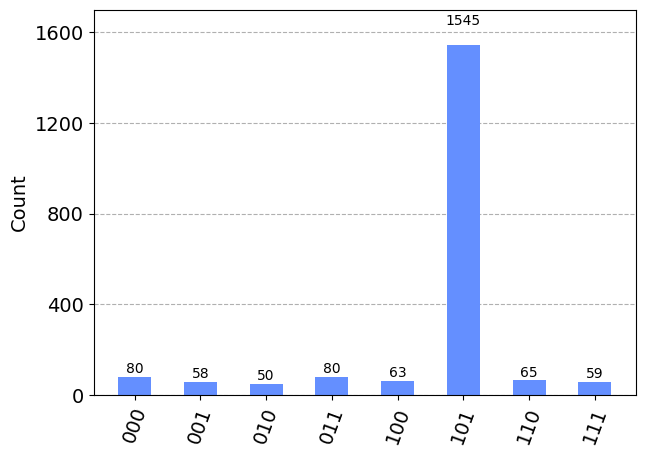

In [ ]:
# Grover Algorithm
from qiskit import QuantumCircuit
from math import pi, sqrt

def phase_oracle_mark_101(n=3):
    """Oracle that phases |101> with -1."""
    qc = QuantumCircuit(n)
    # mark |101> -> X on qubits that should be 0 (qubit 1), then multi-controlled Z, then undo
    qc.x(1)
    qc.h(n-1)
    qc.mcx([0,1], n-1)   # control on q0,q1; target q2 after H acts as Z
    qc.h(n-1)
    qc.x(1)
    return qc

def diffusion(n=3):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

n = 3
grover = QuantumCircuit(n, n)
grover.h(range(n))

oracle = phase_oracle_mark_101(n)
diffuse = diffusion(n)

# Number of iterations ~ pi/4 * sqrt(N)
iters = 1  # for N=8, 1–2 iterations usually enough
for _ in range(iters):
    grover.append(oracle, range(n))
    grover.append(diffuse, range(n))

grover.measure(range(n), range(n))
res = sim.run(transpile(grover, sim), shots=2000).result().get_counts()
print(res)
plot_histogram(res)


# Shor’s Algorithm (Toy Example / Order-Finding Demo)
- Goal : Factor a composite N by finding the order r of a random coprime a mode N (period of a^x mod N).
- For small N like 15 we can demo the flow.

In [16]:
# Full Shor (toy) implementation for N=15 (QPE + postprocessing)
import numpy as np
from math import gcd
from fractions import Fraction
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def build_modular_multiplier(a, N, n_target):
    """Return a 2**n_target x 2**n_target permutation matrix U such that
       U |y> = |(a*y) mod N>  for y in 0..N-1, and U|15> = |15> (leave out-of-range unchanged).
       This is a correct unitary for the target register (toy approach).
    """
    dim = 2**n_target
    U = np.zeros((dim, dim), dtype=complex)
    for y in range(dim):
        if y < N:
            new = (a * y) % N
        else:
            new = y
        U[new, y] = 1.0
    return U

def qpe_shor(N, a, n_count=8, shots=8192, seed=42, verbose=False):
    """
    Run QPE-based order finding for given N and a (toy implementation).
    Returns (counts, circuit) for analysis.
    """
    if gcd(a, N) != 1:
        raise ValueError("a must be coprime with N")

    n_target = int(np.ceil(np.log2(N)))  # for N=15 -> 4 qubits
    if 2**n_target < N:
        n_target += 1

    dim = 2**n_target
    # Build modular multiplication unitary U (size dim x dim)
    U = build_modular_multiplier(a, N, n_target)
    # Prepare simulator
    sim = AerSimulator(seed_simulator=seed)

    # Build circuit: n_count counting qubits + n_target target qubits
    qc = QuantumCircuit(n_count + n_target, n_count)

    # 1) Prepare counting register in uniform superposition
    qc.h(range(n_count))

    # 2) Prepare target register in |1> (we want to find period of a^x mod N on state |1>)
    #    target qubits are placed as qubits [n_count, ..., n_count+n_target-1]
    target_qubits = list(range(n_count, n_count + n_target))
    qc.x(n_count)   # set the LSB of target register to 1 -> integer 1

    # 3) Controlled-U^(2^j) operations
    # We'll implement each controlled-power by making UnitaryGate(U_power).control()
    for j in range(n_count):
        power = 2**j
        U_pow = np.linalg.matrix_power(U, power)
        # create UnitaryGate for U_pow acting on the target register
        u_gate = UnitaryGate(U_pow)
        # controlled version (single control)
        cu = u_gate.control()
        # append with control as counting qubit j and targets as target_qubits in the same order
        qc.append(cu, [j] + target_qubits)

    # 4) inverse QFT on counting register
    qft_dg = QFT(n_count, do_swaps=True).inverse().to_instruction()
    qc.append(qft_dg, range(n_count))

    # 5) measure counting register
    qc.measure(range(n_count), range(n_count))

    # Run
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    if verbose:
        print("Counts (top 10):", sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:10])

    return counts, qc

def find_factors_from_counts(counts, a, N, n_count, top_k=10):
    """
    Examine top peaks from counts and try to extract candidate r via continued fractions,
    then test the candidate r (and small multiples) classically to produce factors.
    Returns (p,q,r,peak_bitstr,phase) or None.
    """
    peaks = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:top_k]
    for bitstr, shots in peaks:
        measured_int = int(bitstr, 2)
        phase = measured_int / (2**n_count)
        # Try continued fraction primary candidate
        frac = Fraction(phase).limit_denominator(N)
        cand_denoms = set()
        cand_denoms.add(frac.denominator)
        # also try neighboring denominators (multiples) and small denominators up to N
        for k in range(1, 8):
            cand_denoms.add(frac.denominator * k)
        for r in sorted(cand_denoms):
            if r <= 0 or r >= N:
                continue
            # r must satisfy a^r mod N == 1
            if pow(a, r, N) != 1:
                continue
            if r % 2 == 1:
                continue
            x = pow(a, r//2, N)
            if x in (0, 1, N-1):
                continue
            p = gcd(x-1, N)
            q = gcd(x+1, N)
            if 1 < p < N and 1 < q < N:
                return (p, q, r, bitstr, phase)
    return None

def shor_full_try(N=15, a_list=None, n_count=8, shots=8192, tries_per_a=3, verbose=True):
    """
    Try Shor for N and a values in a_list (defaults to typical coprimes for 15),
    repeating each a a few times if needed. Returns factors or None.
    """
    if a_list is None:
        a_list = [2, 7, 8, 11, 13]  # reasonable coprimes for 15

    for a in a_list:
        if gcd(a, N) != 1:
            continue
        if verbose:
            print(f"\nTrying a = {a}")
        for attempt in range(tries_per_a):
            counts, qc = qpe_shor(N, a, n_count=n_count, shots=shots, seed=attempt, verbose=verbose)
            # plot histogram (optional)
            # plot_histogram(counts)
            res = find_factors_from_counts(counts, a, N, n_count, top_k=12)
            if res is not None:
                p, q, r, peak, phase = res
                if verbose:
                    print(f"Success for a={a} (attempt {attempt+1}):")
                    print(f"  peak bitstring (count peak): {peak}")
                    print(f"  measured phase ~ {phase:.6f}, candidate r = {r}")
                    print(f"  factors found: {p} and {q}")
                return p, q, a, r, counts, qc
            if verbose:
                print(f"  attempt {attempt+1}: no nontrivial factors found, trying again...")
    if verbose:
        print("Failed to find nontrivial factors — try increasing n_count or shots, or try more a values.")
    return None

# === Run the algorithm for N=15 ===
N = 15
out = shor_full_try(N=15, a_list=[2,7,8,11,13], n_count=8, shots=8192, tries_per_a=4, verbose=True)

if out is not None:
    p, q, a_used, r_found, counts, qc = out
    print(f"\nFinal answer: N={N} factors = {p} * {q} (found using a={a_used}, r={r_found})")
    # show histogram for the successful run
    plot_histogram(counts)
    plt.show()
else:
    print("No factors found — try increasing n_count or shots, or check the modular-multiplier construction.")



Trying a = 2
Counts (top 10): [('01000000', 2086), ('10000000', 2073), ('11000000', 2045), ('00000000', 1988)]
Success for a=2 (attempt 1):
  peak bitstring (count peak): 01000000
  measured phase ~ 0.250000, candidate r = 4
  factors found: 3 and 5

Final answer: N=15 factors = 3 * 5 (found using a=2, r=4)
